In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def load_data(path):
    """
    Load CSV file.
    
    Parameters:
        path. String. File path.
    
    Returns:
        Pandas data frame.
    """
    
    df = pd.read_csv(path, sep=";", header=0, names=["date", "vals"], usecols=[0,1])
    return df

In [3]:
def clean_df(df):
    """
    Data cleaning. 
    Drop duplicates, turn date column into a datetime pandas object and sort it in descending order.
    
    Parameters:
        df: Pandas dataframe. Dataframe coming from load_data() function.
    
    Returns:
        Pandas dataframe. Cleaned dataframe.
    """
    
    df.drop_duplicates(inplace=True)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date", ascending=False).reset_index(drop=True)
    return df

In [4]:
def feature_engineering(original_df):
    """
    Feature engineering.
    Add additional features to improve model's performance.
    Features are:
    - Last day of the month. Boolean.
    - First day of the month. Boolean.
    - Day of the month. Integer ranging from 1 to 31.
    - Day of the week. Integer ranging from 0 to 6 where 0 is Monday and 6 Sunday.
    
    Parameters:
        original_df: Pandas DataFrame. Dataframe coming from clean_df() function.
    
    Returns:
        Enhanced Pandas DataFrame.
    """
    
    df = original_df.copy()
    df["day"] = df["date"].dt.day 
    df["weekdays"] = df["date"].dt.weekday # 0 to 6 where 0 is Monday and 6 Sunday
    df["last_day"] = df["date"].dt.is_month_end.astype("int")
    df["first_day"] = df["date"].dt.is_month_start.astype("int")
    return df

In [5]:
def dummify(df): 
    """
    
    """
    df_wd = pd.get_dummies(df.weekdays, prefix="weekday")
    df_dy = pd.get_dummies(df.day, prefix="day")
    full = pd.concat([df_wd, df_dy, days[["first_day", "last_day", "vals"]]], axis=1)
    return full

In [215]:
def paint_it(df, tit):
    """
    
    """
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(df["date"], df["vals"], label="Raw data")
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_title(tit, size=16)
    ax.set_xlabel("Time", size=14)
    ax.set_ylabel("Values", size=14)
    ax.legend(shadow=True)
    
    return fig

In [7]:
def generate_dfs(df, df_length, amount):
    """
    Given a single dataframe, generate as many as "amount" with a length "df_length".
    E.g.: For df_length and amount set to 100 and 5 respectivily, this function will return
    a list comprised of 5 dataframes with 100 rows each. An error will be raised if 
    the original dataframe's length is fewer than "df_lenght" + "amount".
    
    Parameters:
        df: Pandas DataFrame. Original dataframe.
        df_length: Integer. Number of rows.
        amount: Integer. Number of dataframes.
        
    Return:
        List of dataframes.
    """
    
    if len(df) < df_length + amount:
        raise Exception(f"Dataframe's length {len(df)} should be higher than df_length + amount: ({df_length} + {amount})")
        
    dfs = [df[x:df_length + x].reset_index(drop=True) for x in range(amount)]
    
    return dfs

In [8]:
def train_test_split(df, split=1, split_type="rf"):
    """
    Given a dataframe a some split type, split the dataframe into train and test datasets.
    
    Parameters:
        df: Pandas DataFrame. DataFrame coming from clean_df() or feature_engineering() function.
        split: Integer. Number of values to add to y dataset. Default 1.
        split_type: String. Either "rf" or "lr". Additional modifications depending on the model.
    
    Returns:
        Tuple. NumPy arrays. X_train, X_test, y_train and y_test datasets.
    """
    
    # Setting X and y
    y = df["vals"].values
    X = df["date"].values
    
    if split_type == "rf":
        X = df.loc[:, ~df.columns.isin(["date", "vals"])].values
        
    elif split_type == "lr":
        X = np.arange(len(X), 0, -1).reshape(-1, 1)
        y = y.reshape(-1, 1)
    
    else:
        raise Exception("Wrong split_type. Choose either rf or lr")

    X_test = X[:split]
    X_train = X[split:]
    y_test = y[:split]
    y_train = y[split:]
    
    return X_train, X_test, y_train, y_test

In [9]:
def compute_score(y_true, y_predict):
    """
    Compute error (MAPE) given a prediction and a real value.
    
    Parameters:
        y_true: Float, Integer or numpy array. Actual value.
        y_predict: Float, Integer or numpy array. Forecast value.
    
    Returns:
        Float, Integer or numpy array. Percentage error. The higher, the better.
    """

    score = round(100 * (1 - np.mean(abs(y_true - y_predict) / y_true)), 2)
    return score

In [33]:
def model_prediction(model, X_train, X_test, y_train, y_test):
    """
    Given some X and y values, train any model.
    
    Parameters:
        model: Model object with fit and predict functions.
        X_train: NumPy array. X train dataset.
        X_test: NumPy array. X test dataset.
        y_train: NumPy array. y train dataset.
        y_test: NumPy array. y test dataset.
    
    Returns:
        Tuple. Float, Integer or numpy array. Score and Forecast value.
    """
    
    # Fitting
    model.fit(X_train, y_train)
    
    # Prediction
    y_hat = model.predict(X_test)
    
    # Scoring    
    #score = compute_score(y_true=y_test, y_predict=y_hat)
    score = mean_squared_error(y_true=y_test, y_pred=y_hat)
    
    return score, np.round(y_hat[0], 3)

In [135]:
def lr_vs_rf(df, df_length, lr_pred, rf_pred):
    """
    Given real and forecast values, plot LR vs. RF performance.
    
    Parameters:
        df. Pandas DataFrame.
        df_lenght: Integer. Number of values to plot.
        lr_pred: List of Float or Integers. Forecast values.
        rf_pred: List of Float or Integers. Forecast values.
        
    Returns:
        Matplotlib Figure.
    """
    
    p = df[:df_length]
    f_len = len(rf_pred)

    train_date = p.loc[f_len:, "date"].values
    test_date = p.loc[:f_len-1, "date"].values
    train_vals = p.loc[f_len:, "vals"].values
    test_vals = p.loc[:f_len-1, "vals"].values

    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(train_date, train_vals, "-b", label="_nolegend_")
    ax.plot(test_date, test_vals, "-b", label="True Values")
    ax.plot(test_date, lr_pred, ls="-", color="#f2c707", label="Forecast LR Simple")
    ax.plot(test_date, rf_pred, ls="-", color="#30bd09",label="Forecast RF Enhanced")

    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Values", fontsize=14)
    ax.set_title("Linear Regression vs. Random Forest Regressor", fontsize=16)
    ax.legend(shadow=True, loc=2)
    
    plt.savefig(f"../charts/{table}_lr_vs_rf.png")
    
    return fig

In [138]:
def rf_vs_rf(df, df_length, rf_simple_pred, rf_enhanced_pred):
    """
    Given real and forecast values, plot RF simple vs. RF enhanced performance.
    
    Parameters:
        df. Pandas DataFrame.
        df_lenght: Integer. Number of values to plot.
        rf_simple_pred: List of Float or Integers. Forecast values.
        rf_enhanced_pred: List of Float or Integers. Forecast values.
        
    Returns:
        Matplotlib Figure.
    """
    
    p = df[:100]
    f_len = len(rf_enhanced_pred)

    train_date = p.loc[f_len:, "date"].values
    test_date = p.loc[:f_len-1, "date"].values
    train_vals = p.loc[f_len:, "vals"].values
    test_vals = p.loc[:f_len-1, "vals"].values

    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(train_date, train_vals, "-b", label="_nolegend_")
    ax.plot(test_date, test_vals, "-b", label="True Values")
    ax.plot(test_date, rf_simple_pred, ls="-", color="#ed3528",label="Forecast RF Simple")
    ax.plot(test_date, rf_enhanced_pred, ls="-", color="#30bd09",label="Forecast RF Enhanced")

    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Values", fontsize=14)
    ax.set_title("Random Forest Simple vs. Random Forest Enhanced", fontsize=16)
    ax.legend(shadow=True, loc=2)
    
    plt.savefig(f"../charts/{table}_rf_vs_rf.png")
    
    return fig

In [139]:
def main(path, df_length, amount):
    """
    Main function.
    
    Parameters:
    
    Returns:
    
    """
    
    # Load data from CSV.
    df = load_data(path)
    
    # Data cleaning.
    df = clean_df(df)
    
    # Generate multiple dataframes. Similar to walk forward approach.
    dfs = generate_dfs(df, df_length=df_length, amount=amount)
    
    # Initialize accuracy and forecast dictionaries.
    forecast_dict = {"LR": [], "RF_simple": [], "RF_enhanced": []}
    acc_dict = {"LR": [], "RF_simple": [], "RF_enhanced": []}
    
    # Main loop. Go through all dataframes testing LR and RF.
    for d in dfs:
        # Linear Regression.
        model = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(d, split=1, split_type="lr")
        acc, prediction = model_prediction(model, X_train, X_test, y_train, y_test)

        acc_dict["LR"].append(acc)
        forecast_dict["LR"].append(prediction[0])

        # Random Forest without feature engineering.
        X_train, X_test, y_train, y_test = train_test_split(d, split=1, split_type="lr")
        model = RandomForestRegressor()
        acc, prediction = model_prediction(model, X_train, X_test, y_train.ravel(), y_test.ravel())

        acc_dict["RF_simple"].append(acc)
        forecast_dict["RF_simple"].append(prediction)

        # Random Forest.
        enhanced_df = feature_engineering(d)
        X_train, X_test, y_train, y_test = train_test_split(enhanced_df, split=1, split_type="rf")
        model = RandomForestRegressor()
        acc, prediction = model_prediction(model, X_train, X_test, y_train, y_test)

        acc_dict["RF_enhanced"].append(acc)
        forecast_dict["RF_enhanced"].append(prediction)
        
    # Plotting results
    fig1 = lr_vs_rf(df, df_length, forecast_dict["LR"], forecast_dict["RF_enhanced"])
    fig2 = rf_vs_rf(df, df_length, forecast_dict["RF_simple"], forecast_dict["RF_enhanced"])
    
    return fig1, fig2

In [151]:
r2_acc = {"t1": [], "t2": [], "t3": [], "t4": []}

In [259]:
table = "t4"
df = load_data(f"../data/{table}.csv")

In [260]:
df.head()

,date,vals
0,2021-02-26,6109
1,2021-02-25,811
2,2021-02-24,908
3,2021-02-23,1056
4,2021-02-22,1090


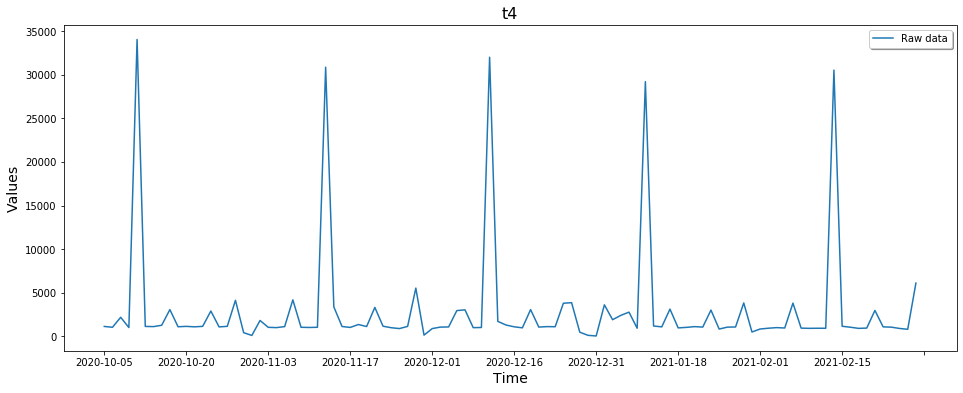

In [261]:
fig4 = paint_it(df[::-1][-100:], table)
#fig.savefig(f"../charts/{table}_raw.png")

In [239]:
df = clean_df(df)

dfs = generate_dfs(df, df_length=100, amount=20)

In [240]:
forecast_dict = {"LR": [], "RF_simple": [], "RF_enhanced": []}
acc_dict = {"LR": [], "RF_simple": [], "RF_enhanced": []}

for d in dfs:
    # Linear Regression.
    model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(d, split=1, split_type="lr")
    acc, prediction = model_prediction(model, X_train, X_test, y_train, y_test)

    acc_dict["LR"].append(acc)
    forecast_dict["LR"].append(prediction[0])

    # Random Forest without feature engineering.
    #X_train, X_test, y_train, y_test = train_test_split(d, split=1, split_type="lr")
    #model = RandomForestRegressor()
    #acc, prediction = model_prediction(model, X_train, X_test, y_train.ravel(), y_test.ravel())
    
    enhanced_df = feature_engineering(d)
    X_train, X_test, y_train, y_test = train_test_split(enhanced_df, split=1, split_type="rf")
    model = LinearRegression()
    acc, prediction = model_prediction(model, X_train, X_test, y_train, y_test)

    acc_dict["RF_simple"].append(acc)
    forecast_dict["RF_simple"].append(prediction)

    # Random Forest.
    enhanced_df = feature_engineering(d)
    X_train, X_test, y_train, y_test = train_test_split(enhanced_df, split=1, split_type="rf")
    model = RandomForestRegressor()
    acc, prediction = model_prediction(model, X_train, X_test, y_train, y_test)
    
    acc_dict["RF_enhanced"].append(acc)
    forecast_dict["RF_enhanced"].append(prediction)

print("Process completed")

Process completed


In [187]:
r_1 = round(r2_score(df["vals"][:20], forecast_dict["LR"]),2)
r_2 = round(r2_score(df["vals"][:20], forecast_dict["RF_simple"]),2)
r_3 = round(r2_score(df["vals"][:20], forecast_dict["RF_enhanced"]),2)
rs = [r_1, r_2, r_3]
rs
r2_acc[table] = rs
r2_acc

[-0.03, -0.52, 0.86]

{'t1': [0.66, 0.88, -65.13],
 't2': [0.02, 0.27, 0.96],
 't3': [-0.2, -0.46, 0.9],
 't4': [-0.03, -0.52, 0.86]}

In [188]:
#a = pd.DataFrame(r2_acc).T

In [189]:
a.columns = ["LR_simple", "RF_simple", "RF_enhanced"]
a

,LR_simple,RF_simple,RF_enhanced
t1,0.66,0.88,-65.94
t2,0.02,0.27,0.97
t3,-0.20,-0.40,0.90
t4,-0.03,-0.72,0.92


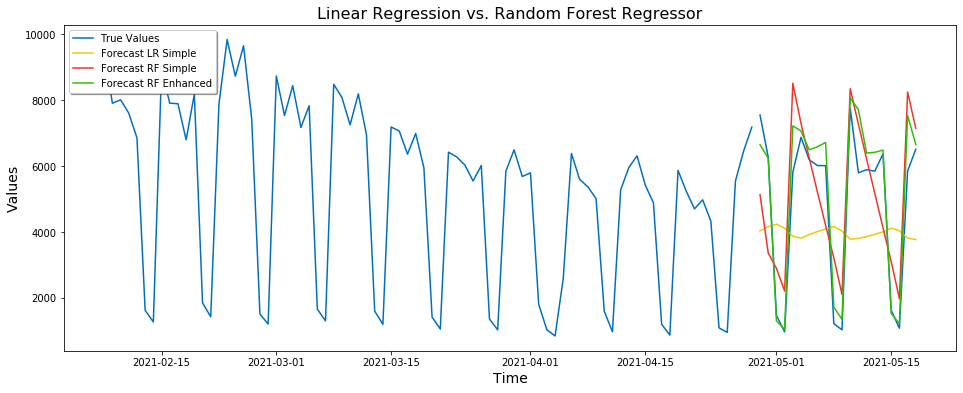

In [205]:
p = df[:100]
f_len = len(forecast_dict["RF_enhanced"])

train_date = p.loc[f_len:, "date"].values
test_date = p.loc[:f_len-1, "date"].values
train_vals = p.loc[f_len:, "vals"].values
test_vals = p.loc[:f_len-1, "vals"].values

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train_date, train_vals, color="#006fbf", label="_nolegend_")
ax.plot(test_date, test_vals, color="#006fbf", label="True Values")
ax.plot(test_date, forecast_dict["LR"], color="#f2c707", label="Forecast LR Simple")
ax.plot(test_date, forecast_dict["RF_simple"], color="#ed3528",label="Forecast RF Simple")
ax.plot(test_date, forecast_dict["RF_enhanced"], color="#30bd09",label="Forecast RF Enhanced")

ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Values", fontsize=14)
ax.set_title("Linear Regression vs. Random Forest Regressor", fontsize=16)
ax.legend(shadow=True, loc=2)

plt.savefig(f"../charts/{table}_full.png");

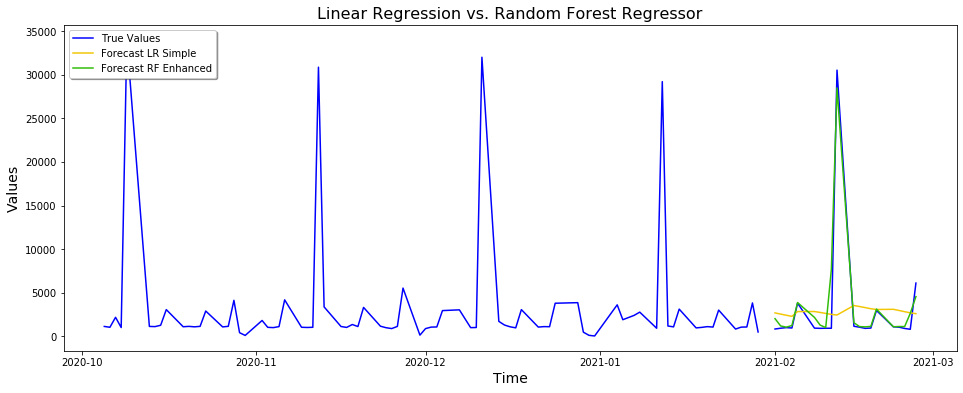

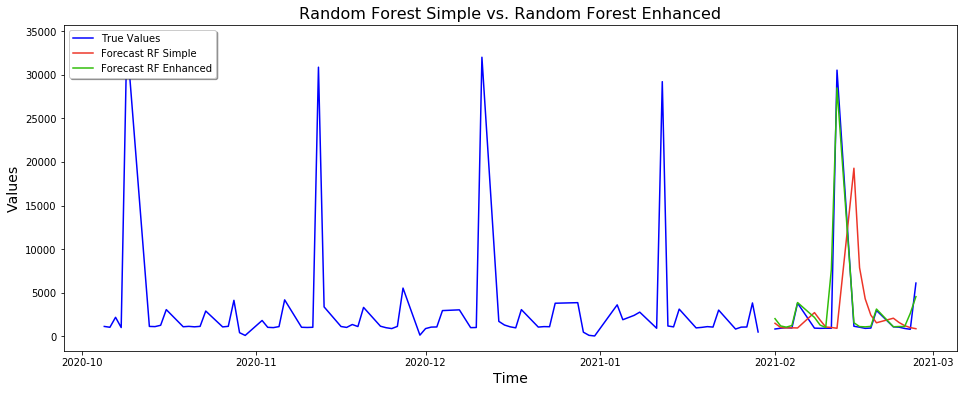

In [191]:
fig1, fig2 = main(path=f"../data/{table}.csv", df_length=100, amount=20)